In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [3]:
# read the dataset
df = pd.read_csv("../datasets/polls-50k.csv")
# remove the column 'class' if present as this causes an internal error
if 'class' in df.columns:
    df = df.drop(columns=['class'])
# cut_off can be set to limit the number of features
cut_off = 500
if cut_off < df.shape[1]:
    X, y = df.iloc[:,:cut_off].values, df.iloc[:,-1].values
    h = df.columns[:cut_off]
else:
    X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values
    h = df.columns[:-1]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)
# convert the train and test data into dataframes
X_train, X_test = pd.DataFrame(X_train, columns=h), pd.DataFrame(X_test, columns=h)
y_train, y_test = pd.DataFrame(y_train, columns=['relevant']), pd.DataFrame(y_test, columns=['relevant'])

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39718 entries, 0 to 39717
Columns: 500 entries, rt to कर
dtypes: float64(500)
memory usage: 151.5 MB


In [5]:
# first 20 features
X_train.iloc[:,:20].head()

,rt,vote,tta,winner,follow,coupon,ticket,giveaway,get,like,voting,free,poll,rules,the,amp,trump,artist,de,ga
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
"""GitHub GOSDT key params:
    regularization -- Note: We highly recommend setting the regularization to a value larger than 1/num_samples.
    depth_budget -- limits the max depth of the tree
"""
print(f"1/num_samples: {1/len(y)}")

1/num_samples: 1.8882888326598438e-05


In [7]:
from model.gosdt import GOSDT
# set GOSDT configuration
config = {
            "regularization": 0.008,#0.002, 
            # regularization penalizes the tree with more leaves. We recommend to set it to relative high value to find a sparse tree.  
            "depth_budget": 6, # limits the max depth of the tree
            "time_limit": 1500, # training time limit in seconds
            # "similar_support": False
            # "verbose": True,
        }

model = GOSDT(config)

# train GOSDT 
model.fit(X_train, y_train)
print("evaluate the model, extracting tree and scores", flush=True)

prec, rec, f1, supp = precision_recall_fscore_support(y_test, model.predict(X_test))
test_acc = model.score(X_test, y_test)
train_acc = model.score(X_train, y_train)
n_leaves = model.leaves()
n_nodes = model.nodes()
time = model.utime

# print(f"Model training time: {time}")
print(f"Training accuracy: {train_acc}, Test accuracy: {test_acc}")
# print(f"Error: {model.error(X_train, y_train)}")
print("Metrics per class: [0 1] with 1=Relevant")
print(f"Precision: {np.round(prec,4)}, Recall: {np.round(rec,4)}, F1: {np.round(f1,4)}, Support: {supp}")
print(f"# of leaves: {n_leaves}")
df_eval = pd.DataFrame({"precision": prec, "recall": rec, "f1": f1, "support": supp})
print(model.tree)

gosdt reported possible timeout.
training completed. -1.000/-1.000/-1.000 (user, system, wall), mem=0 MB
bounds: [0.024604..0.035286] (0.010682) loss=0.019286, iterations=339999
evaluate the model, extracting tree and scores
Training accuracy: 0.9807140339392718, Test accuracy: 0.9810422960725076
Metrics per class: [0 1] with 1=Relevant
Precision: [0.9986 0.6764], Recall: [0.9817 0.9644], F1: [0.9901 0.7951], Support: [12735   505]
# of leaves: 2
if trump = 1.0 then:
    predicted class: 1
    misclassification penalty: 0.018
    complexity penalty: 0.008

else if trump != 1.0 then:
    predicted class: 0
    misclassification penalty: 0.001
    complexity penalty: 0.008


In [17]:
print(f"""Current parameters:
    "regularization": {config['regularization']},
    "depth_budget": {config['depth_budget']},
    Training dataset size: rows:{len(y_train)}, features(words):{len(X_train.columns)},
    """)

Current parameters:
    "regularization": 0.008,
    "depth_budget": 6,
    Training dataset size: rows:39718, features(words):500,
    


In [8]:
model.latex()

'[ $trump  \\eq  1.0$ [ $class$ [ $1$ ] ] [ $class$ [ $0$ ] ] ]'

#### Sci_kit learn standard decision tree

In [14]:
from sklearn import tree

# create a decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

# train the classifier
clf.fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
prec, rec, f1, supp = precision_recall_fscore_support(y_test, clf.predict(X_test)) #, pos_label=1, average='binary')
print(f"Training accuracy: {train_acc}, Test accuracy: {test_acc}")
print(f"Precision: {np.round(prec,4)}, Recall: {np.round(rec,4)}, F1: {np.round(f1,4)}, Support: {supp}")
print(f"# of leaves: {clf.get_n_leaves()}, depth: {clf.get_depth()}")

# add row to df_eval
df_eval.loc[len(df_eval)] = [prec[0], rec[0], f1[0], supp[0]]
df_eval.loc[len(df_eval)] = [prec[1], rec[1], f1[1], supp[1]]
df_eval.index = ['GOSDT 0', 'GOSDT 1', 'DT 0', 'DT 1']
df_eval

Training accuracy: 0.9860264867314568, Test accuracy: 0.986178247734139
Precision: [0.9971 0.7614], Recall: [0.9885 0.9287], F1: [0.9928 0.8368], Support: [12735   505]
# of leaves: 32, depth: 6


,precision,recall,f1,support
GOSDT 0,0.998562,0.981704,0.990061,12735.0
GOSDT 1,0.676389,0.964356,0.795102,505.0
DT 0,0.997148,0.988457,0.992784,12735.0
DT 1,0.761364,0.928713,0.836753,505.0


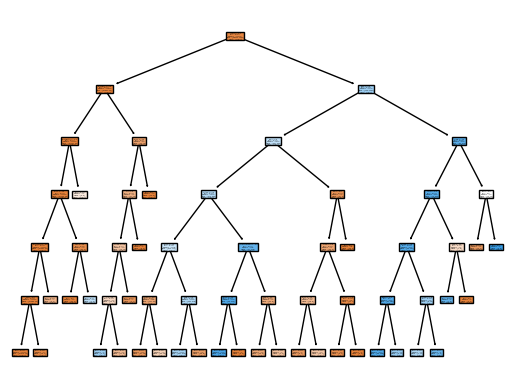

In [15]:
_ = tree.plot_tree(clf, feature_names=h, class_names=['irrelevant', 'relevant'], filled=True)

In [11]:
tree_text = tree.export_text(clf, feature_names=h.tolist())
print(tree_text)

|--- trump <= 0.50
|   |--- biden <= 0.50
|   |   |--- election <= 0.50
|   |   |   |--- class: 0
|   |   |--- election >  0.50
|   |   |   |--- class: 0
|   |--- biden >  0.50
|   |   |--- rt <= 0.50
|   |   |   |--- class: 1
|   |   |--- rt >  0.50
|   |   |   |--- class: 0
|--- trump >  0.50
|   |--- who <= 0.50
|   |   |--- clinton <= 0.50
|   |   |   |--- class: 1
|   |   |--- clinton >  0.50
|   |   |   |--- class: 1
|   |--- who >  0.50
|   |   |--- amp <= 0.50
|   |   |   |--- class: 1
|   |   |--- amp >  0.50
|   |   |   |--- class: 1



In [13]:
# print(f'Decision path: {clf.decision_path(X)}')